<a href="https://colab.research.google.com/github/jcandane/RTHF_DensityMatrix/blob/main/RTHF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyscf 
!git clone https://github.com/jcandane/RTHF_DensityMatrix

fatal: destination path 'RTHF_DensityMatrix' already exists and is not an empty directory.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
sys.path.insert(1, './RTHF_DensityMatrix/')
from pyscf_interface import *

plt.style.use("dark_background")

In [33]:
def Expm(A):
    Eigenvalues, Eigenvectors = np.linalg.eig( A )
    return Eigenvectors @  np.diag(  np.exp( Eigenvalues)  )  @ np.linalg.inv(Eigenvectors)

def getAO(DA, DB, Ca, Cb):
    ## transform MO density into an AO density 
    return ( (Ca)@ DA @(Ca.T) ), ( (Cb)@ DB @(Cb.T) )

def getMO(FA, FB, Ca, Cb):
    ## transform AO Fock into an MO Fock 
    return ( (Ca.T)@ FA @(Ca) ), ( (Cb.T)@ FB @(Cb) )

def getFM(Da, Db, H, I):
    J  = np.einsum('ABCD, CD -> AB', I, Da + Db , optimize=True)
    Kα = np.einsum('ABCD, BC -> AD', I, Da , optimize=True)
    Kβ = np.einsum('ABCD, BC -> AD', I, Db , optimize=True)
    Fα = H + J - Kα
    Fβ = H + J - Kβ
    return Fα, Fβ

def RTHF_Unitary(uhf_pyscf, dt = 0.002, dT = 100, field=None):

    if field is None:
      field = E_field()
      field.E0 = 0.
      field.Γ  = 100.

    tsteps = int(dT/dt)
    DA_mo, DB_mo = (uhf_pyscf).mo_occ
    DA_mo  = np.diag(DA_mo).astype(complex)
    DB_mo  = np.diag(DB_mo).astype(complex)

    Ca, Cb = (uhf_pyscf).mo_coeff
    En = (uhf_pyscf).energy_nuc()
    D  = (uhf_pyscf.mol).intor("int1e_r")
    H  = (uhf_pyscf.mol).intor("int1e_kin")
    H += (uhf_pyscf.mol).intor("int1e_nuc")
    I  = (uhf_pyscf.mol).intor("int2e")

    d_tx   = np.zeros((tsteps, 3))
    energy = np.zeros(tsteps)
    trace  = np.zeros(tsteps)
    for step in tqdm(range(tsteps)):
        t = (step) * dt

        DA_ao, DB_ao = getAO(DA_mo, DB_mo, Ca, Cb)
        Fa_ao, Fb_ao = getFM(DA_ao, DB_ao,  H,  I) - np.einsum('xAB, x -> AB', D, field.getEE(t) )
        FA_mo, FB_mo = getMO(Fa_ao, Fb_ao, Ca, Cb)

        #### probe
        d_tx[step]   = np.einsum('xAB, AB -> x', D, ( DA_ao + DB_ao ).real )
        trace[step]  = np.trace(DA_mo.real + DA_mo.real)
        energy[step] = np.einsum("AB, AB -> ", H + Fa_ao, DA_ao/2).real + np.einsum("AB, AB -> ", H + Fb_ao, DB_ao/2).real + En

        UA  = Expm( -1j*(dt)*FA_mo )
        UB  = Expm( -1j*(dt)*FB_mo )

        DA_mo = (UA) @ DA_mo @ ((UA).conj().T)
        DB_mo = (UB) @ DB_mo @ ((UB).conj().T)

    t     = np.arange(0, dT, dt)
    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)

    return t, d_tx, energy, trace

def RTHF_UT(uhf_object, DA_t=None, DB_t=None, dt = 0.002, dT = 100, onoff=1.0, field=None, MD=False, Current=False, probe=False):
    tsteps = int(dT/dt)
    
    if DA_t is None:
        DA_t = 1.*(uhf_object.Da_mo)
    if DB_t is None:
        DB_t = 1.*(uhf_object.Db_mo)
    if field is None:
        field = E_field()
        field.E0 = 0.
        field.Γ  = 100.
    
    if probe:
        energy = np.zeros(tsteps)
        trace  = np.zeros(tsteps)
    d_tx   = np.zeros((tsteps, 3))
    for step in tqdm(range(tsteps)):
        t = (step) * dt
        
        DA_ao, DB_ao = uhf_object.getAO(DA_t, DB_t)
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        FA, FB = uhf_object.getMO(FA_ao, FB_ao)
        
        #### probe
        d_tx[step]  = np.einsum('xAB, AB -> x', uhf_object.D, ( DA_ao + DB_ao ).real )
        if probe:
            trace[step]  = np.trace(DA_t.real + DB_t.real)
            energy[step] = uhf_object.get_Euhf(DA_ao, DB_ao, FA_ao, FB_ao).real
        ####
        
        # compute propagators
        UA  = Expm( -1j*(dt)*FA )
        UB  = Expm( -1j*(dt)*FB )
        #Unit[step] = np.abs(np.einsum("pq -> ", UA @ (UA.conj().T) - np.eye(len(UA)).astype(complex) ))
        
        ### full step forward
        DA_t  = (UA) @ DA_t @ ((UA).conj().T)
        DB_t  = (UB) @ DB_t @ ((UB).conj().T)
        
    
    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)
    
    if probe:
        return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, trace, energy
    else:
        return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx

In [47]:
field3 = E_field()
field3.E0 = 1e-5
field3.ω  = 0.25
field3.Γ  = 1.
field3.vector = np.array([1.,1.,1.])

### Hydrogen cyanide / HCN
Z_HCN = np.array(["H", "Li"])
R_HCN = np.array([[ 0.0000,    0.0000,    0.0000], [ 1.6000,    0.0000,    0.0000]])

mol = gto.M(atom="H 0.0 0.0 0.0; Li 1.6 0.0 0.0")
mol.basis = "sto-3g"
CoM = np.einsum("i, ix-> x", (mol).atom_mass_list(isotope_avg=True), (mol).atom_coords() ) / np.sum( (mol).atom_mass_list(isotope_avg=True) )
(mol).set_common_orig_( CoM )

UHF_pyscf = scf.UHF(mol)
UHF_pyscf.conv_tol = 1e-14
UHF_pyscf.kernel()

HCN = pyscf_UHF()
HCN.initialize(xyz=R_HCN, Z=Z_HCN, charge=0, basis="sto-3g")
HCN.Calc()

converged SCF energy = -7.86186476980865  <S^2> = 6.6613381e-16  2S+1 = 1


100%|██████████| 5000/5000 [00:08<00:00, 577.31it/s]


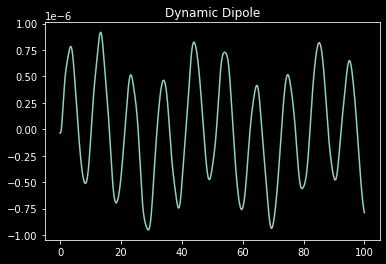

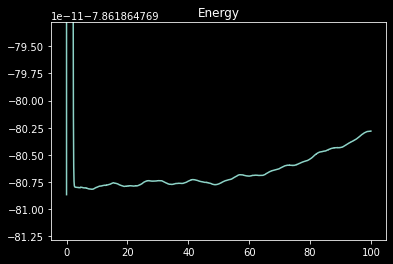

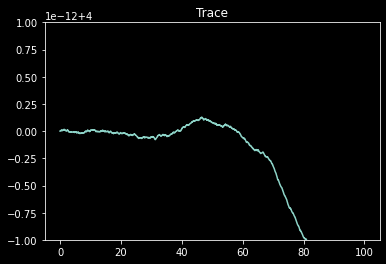

In [48]:
t, d_tx, energy, trace = RTHF_Unitary(UHF_pyscf, dt = 0.02, dT = 100, field=field3)

plt.plot(t, d_tx[:,0])
plt.title("Dynamic Dipole")
plt.show()

ε = 1e-11
plt.plot(t, energy)
plt.ylim([ energy[-1] - ε, energy[-1] + ε])
plt.title("Energy")
plt.show()

ε = 1e-12
plt.plot(t, trace)
plt.ylim([ trace[0] - ε, trace[0] + ε])
plt.title("Trace")
plt.show()

100%|██████████| 5000/5000 [00:09<00:00, 544.21it/s]


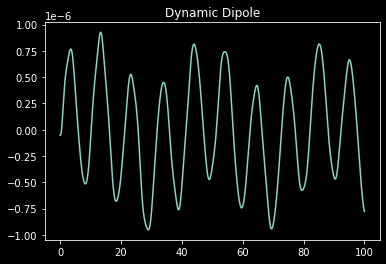

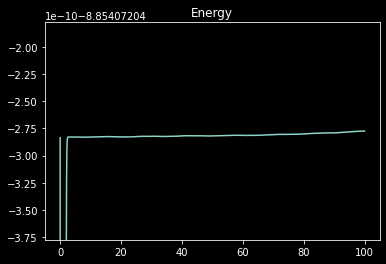

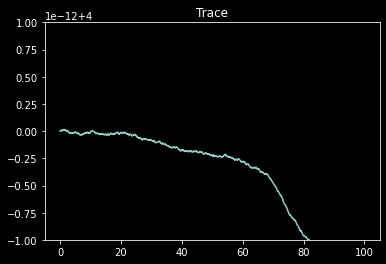

In [39]:
t, d_ut, tr_ut, E_ut = RTHF_UT(HCN, dt = 0.02, dT =100, field=field3, probe=True)

plt.plot(t, d_ut[:,0])
plt.title("Dynamic Dipole")
plt.show()

ε = 1e-10
plt.plot(t, E_ut)
plt.ylim([ E_ut[-1] - ε, E_ut[-1] + ε])
plt.title("Energy")
plt.show()

ε = 1e-12
plt.plot(t, tr_ut)
plt.ylim([ tr_ut[0] - ε, tr_ut[0] + ε])
plt.title("Trace")
plt.show()